Manejo incoherencias y creacion de columna cuentas diarias

In [2]:
import pandas as pd
import requests

# --- 1. CARGA DE DATOS ---
url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()

    # Desanidar columnas con diccionarios
    df = pd.json_normalize(data)

    # --- 2. LIMPIEZA Y CORRECCIÓN DE DATOS ---

    # Rellenar valores faltantes
    fill_values = {
        'customer.gender': 'Desconocido',
        'phone.PhoneService': 'No',
        'internet.InternetService': 'No',
        'customer.SeniorCitizen': 0,
        'account.Contract': 'Desconocido',
        'account.PaymentMethod': 'Desconocido'
    }
    for col, val in fill_values.items():
        if col in df.columns:
            df[col] = df[col].fillna(val)  # Asignación para evitar FutureWarning

    # Eliminar duplicados
    df = df.drop_duplicates()

    # Convertir tipos de datos
    if 'customer.SeniorCitizen' in df.columns:
        df['customer.SeniorCitizen'] = df['customer.SeniorCitizen'].astype(int)
    if 'Churn' in df.columns:
        df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # Normalizar categorías
    if 'account.Contract' in df.columns:
        df['account.Contract'] = df['account.Contract'].replace({
            'One year': '1 Year',
            'Two year': '2 Years'
        })
    if 'account.PaymentMethod' in df.columns:
        df['account.PaymentMethod'] = df['account.PaymentMethod'].replace({
            'Credit card (automatic)': 'Credit card (Auto)',
            'Bank transfer (automatic)': 'Bank Transfer'
        })

    # Crear columna útil de internet
    if 'internet.InternetService' in df.columns:
        df['HasInternetService'] = df['internet.InternetService'] != 'No'

    # --- 3. CREAR LA COLUMNA "Cuentas_Diarias" ---
    if 'account.Charges.Monthly' in df.columns:
        df['Cuentas_Diarias'] = (df['account.Charges.Monthly'] / 30).round(2)
    else:
        print("No se encontró la columna 'account.Charges.Monthly'. Verificá el nombre de la columna.")

    # --- 4. REVISIÓN FINAL ---
    print("DataFrame limpio y con 'Cuentas_Diarias':")
    print(df.head())
    print("\nTipos de datos:")
    print(df.dtypes)

    # Valores únicos por columna categórica
    cat_cols = ['customer.gender', 'phone.PhoneService', 'internet.InternetService', 'account.Contract', 'account.PaymentMethod']
    for col in cat_cols:
        if col in df.columns:
            print(f"{col}: {df[col].unique()}")

else:
    print("Error al obtener los datos:", response.status_code)


DataFrame limpio y con 'Cuentas_Diarias':
   customerID  Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    0.0          Female                       0              Yes   
1  0003-MKNFE    0.0            Male                       0               No   
2  0004-TLHLJ    1.0            Male                       0               No   
3  0011-IGKFF    1.0            Male                       1              Yes   
4  0013-EXCHZ    1.0          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes         

Eliminación de columnas sin valor predictivo

En este paso se eliminan las columnas que no aportan valor al análisis ni a los modelos predictivos. Estas variables, como los identificadores únicos, no tienen relación con el comportamiento de cancelación y pueden incluso afectar negativamente el rendimiento de los modelos.

En este dataset, la columna customerID cumple únicamente la función de identificar al cliente, sin aportar información relevante para predecir la evasión. Por esta razón, se procede a eliminarla antes de continuar con el análisis.

In [3]:
# Eliminación de columnas que no aportan valor al análisis
# En este caso, la columna 'customerID' es un identificador único que no ayuda a predecir la cancelación.

df = df.drop(columns=['customerID'])

# Verificamos que la columna fue eliminada
df.head()

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,...,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,HasInternetService,Cuentas_Diarias
0,0.0,Female,0,Yes,Yes,9,Yes,No,DSL,No,...,Yes,Yes,No,1 Year,Yes,Mailed check,65.6,593.3,True,2.19
1,0.0,Male,0,No,No,9,Yes,Yes,DSL,No,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4,True,2.00
2,1.0,Male,0,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,True,2.46
3,1.0,Male,1,Yes,No,13,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,True,3.27
4,1.0,Female,1,Yes,No,3,Yes,No,Fiber optic,No,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4,True,2.80


Descripción
En este paso se transforman las variables categóricas a un formato numérico, ya que los algoritmos de machine learning requieren datos numéricos para procesar la información. Una técnica común y efectiva es el one-hot encoding, que consiste en crear variables binarias (0 o 1) para representar cada categoría.

Este proceso permite que las variables categóricas sean utilizadas en los modelos sin introducir sesgos por asignación arbitraria de números.

In [4]:
# Identificar columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns
print("Columnas categóricas:", cat_cols.tolist())

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Verificar resultado
df_encoded.head()


Columnas categóricas: ['customer.gender', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Total']


,Churn,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,HasInternetService,Cuentas_Diarias,customer.gender_Male,customer.Partner_Yes,customer.Dependents_Yes,phone.PhoneService_Yes,...,account.Charges.Total_995.35,account.Charges.Total_996.45,account.Charges.Total_996.85,account.Charges.Total_996.95,account.Charges.Total_997.65,account.Charges.Total_997.75,account.Charges.Total_998.1,account.Charges.Total_999.45,account.Charges.Total_999.8,account.Charges.Total_999.9
0,0.0,0,9,65.6,True,2.19,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,0.0,0,9,59.9,True,2.00,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,1.0,0,4,73.9,True,2.46,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,1.0,1,13,98.0,True,3.27,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,1.0,1,3,83.9,True,2.80,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


## Verificación de la Proporción de Cancelación (Churn)

**Descripción**  
Calcula la proporción de clientes que cancelaron en relación con los que permanecieron activos.  
Evalúa si existe un desbalance entre las clases, ya que esto puede impactar en los modelos predictivos y en el análisis de los resultados.


Conteo de clientes:
Churn
0.0    5174
1.0    1869
Name: count, dtype: int64

Proporción de clientes:
Churn
0.0    0.73463
1.0    0.26537
Name: proportion, dtype: float64


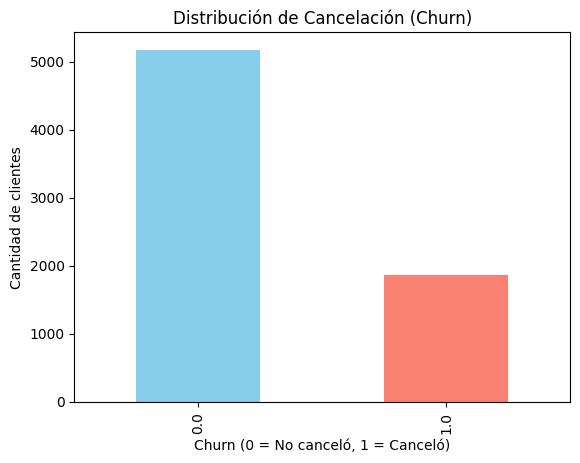

In [5]:
# Verificación de la proporción de cancelación (Churn)

# Conteo de valores de la variable churn
churn_counts = df['Churn'].value_counts()

# Cálculo de proporciones
churn_proportions = df['Churn'].value_counts(normalize=True)

print("Conteo de clientes:")
print(churn_counts)
print("\nProporción de clientes:")
print(churn_proportions)

# Visualización con gráfico de barras
import matplotlib.pyplot as plt

churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Distribución de Cancelación (Churn)")
plt.xlabel("Churn (0 = No canceló, 1 = Canceló)")
plt.ylabel("Cantidad de clientes")
plt.show()


### Normalización o Estandarización (si es necesario)

**Descripción**  
Se evalúa la necesidad de normalizar o estandarizar los datos, dependiendo de los modelos que se vayan a aplicar.  
- Modelos basados en distancia, como **KNN, SVM, Regresión Logística y Redes Neuronales**, requieren este preprocesamiento.  
- Modelos basados en árboles, como **Decision Tree, Random Forest y XGBoost**, no son sensibles a la escala de los datos y no requieren normalización o estandarización.  


In [7]:
from sklearn.preprocessing import StandardScaler

# Seleccionar solo columnas numéricas
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
df_scaled = df.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

# Verificar resultado
df_scaled.head()


,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,...,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,HasInternetService,Cuentas_Diarias
0,-0.601023,Female,-0.440736,Yes,Yes,-0.950200,Yes,No,DSL,No,...,Yes,Yes,No,1 Year,Yes,Mailed check,0.029206,593.3,True,0.032567
1,-0.601023,Male,-0.440736,No,No,-0.950200,Yes,Yes,DSL,No,...,No,No,Yes,Month-to-month,No,Mailed check,-0.159990,542.4,True,-0.156613
2,1.663829,Male,-0.440736,No,No,-1.153700,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,0.304702,280.85,True,0.301401
3,1.663829,Male,2.268932,Yes,No,-0.787401,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,1.104635,1237.85,True,1.107902
4,1.663829,Female,2.268932,Yes,No,-1.194400,Yes,No,Fiber optic,No,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,0.636624,267.4,True,0.639932


### Análisis de Correlación

**Descripción**  
Se visualiza la matriz de correlación para identificar relaciones entre las variables numéricas.  
Se presta especial atención a aquellas variables que muestran una mayor correlación con la cancelación (Churn), ya que pueden ser fuertes candidatas para el modelo predictivo.


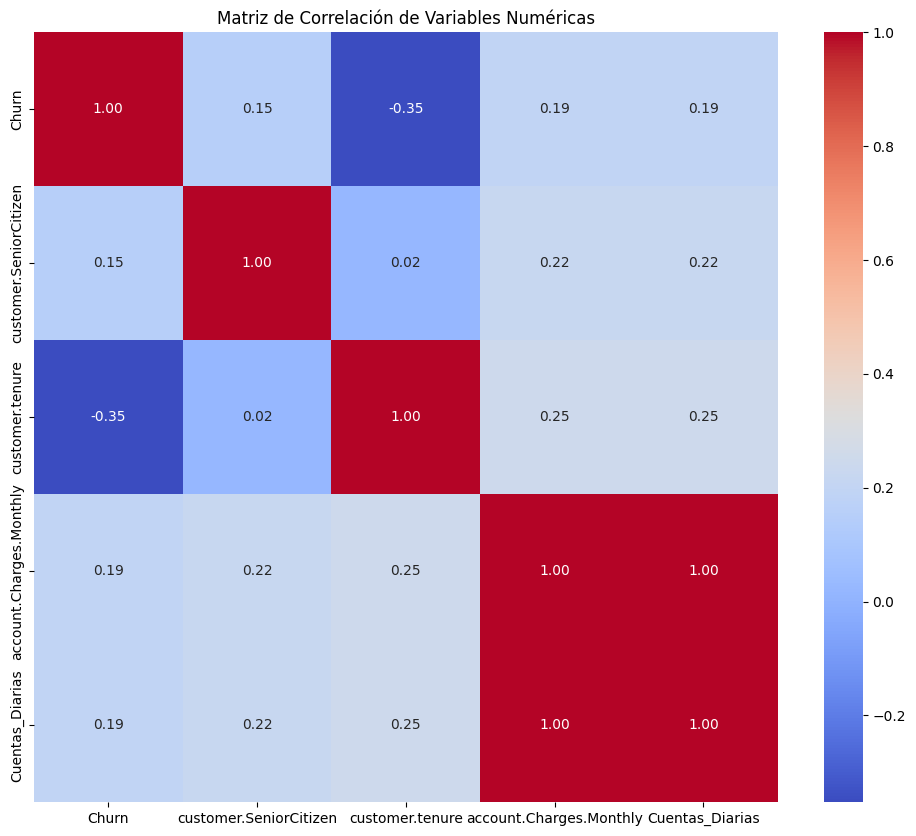

Correlación de variables con Churn:
Churn                      1.000000
Cuentas_Diarias            0.193412
account.Charges.Monthly    0.193356
customer.SeniorCitizen     0.150889
customer.tenure           -0.352229
Name: Churn, dtype: float64


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo columnas numéricas
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Calcular matriz de correlación solo con variables numéricas
corr_matrix = df[numerical_cols].corr()

# Visualizar con un heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()

# Correlación de todas las variables numéricas con 'Churn'
churn_corr = corr_matrix['Churn'].sort_values(ascending=False)
print("Correlación de variables con Churn:")
print(churn_corr)


### Análisis Dirigido

**Descripción**  
Se investiga cómo variables específicas se relacionan con la cancelación (Churn).  
Algunos ejemplos relevantes:  
- Tiempo de contrato (`customer.tenure`) × Cancelación  
- Gasto total (`account.Charges.Total`) × Cancelación  

Se utilizan gráficos como **boxplots** o **scatter plots** para visualizar patrones y posibles tendencias, lo que permite identificar variables que influyen en la probabilidad de cancelación.


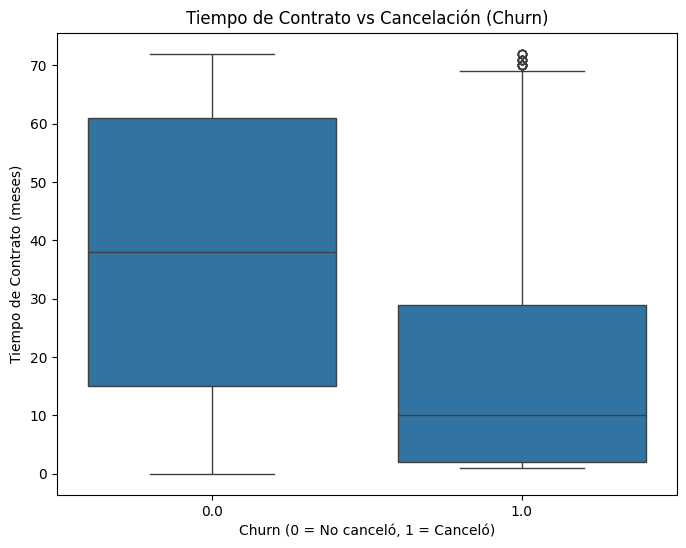

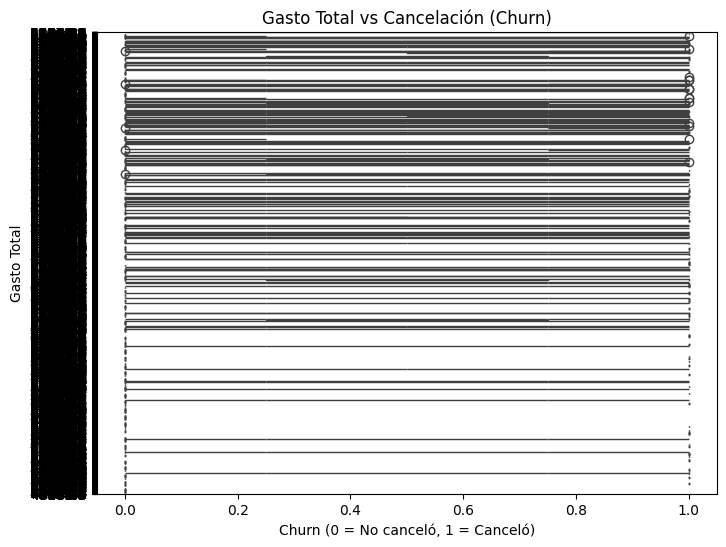

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot: Tiempo de contrato vs Churn
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn', y='customer.tenure', data=df)
plt.title("Tiempo de Contrato vs Cancelación (Churn)")
plt.xlabel("Churn (0 = No canceló, 1 = Canceló)")
plt.ylabel("Tiempo de Contrato (meses)")
plt.show()

# Boxplot: Gasto total vs Churn
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn', y='account.Charges.Total', data=df)
plt.title("Gasto Total vs Cancelación (Churn)")
plt.xlabel("Churn (0 = No canceló, 1 = Canceló)")
plt.ylabel("Gasto Total")
plt.show()


### Separación de Datos

**Descripción**  
Se divide el conjunto de datos en **entrenamiento** y **prueba** para poder evaluar el rendimiento del modelo de manera objetiva.  
Una división común es 70% para entrenamiento y 30% para prueba, aunque también se puede usar 80/20 dependiendo del tamaño de la base de datos.


In [12]:
# Eliminar filas donde Churn es NaN
df = df.dropna(subset=['Churn'])

# Separar variables predictoras y variable objetivo
X = df.drop('Churn', axis=1)
y = df['Churn']

# Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (5634, 21)
Tamaño del conjunto de prueba: (1409, 21)


### Creación de Modelos

**Descripción**  
Se crean al menos dos modelos diferentes para predecir la cancelación de clientes (Churn):

1. **Regresión Logística** (requiere normalización)  
   - Este modelo es sensible a la escala de los datos, por lo que se recomienda normalizar las variables numéricas antes de entrenarlo.  
2. **Random Forest** (no requiere normalización)  
   - Este modelo no depende de la escala de los datos y puede manejar directamente variables numéricas y categóricas codificadas.

Esta combinación permite comparar el desempeño de modelos sensibles y no sensibles a la escala de los datos.


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Separar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# One-Hot Encoding para variables categóricas
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Asegurar que tengan las mismas columnas
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# --- Normalización solo para regresión logística ---
scaler = StandardScaler()
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train_encoded[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test_encoded[num_cols])

# --- Modelo 1: Regresión Logística ---
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)

# --- Modelo 2: Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

print("Modelos entrenados correctamente.")


Modelos entrenados correctamente.


### Evaluación de los Modelos

**Descripción**  
Se evalúa cada modelo utilizando métricas de desempeño como:  
- **Exactitud (Accuracy)**  
- **Precisión (Precision)**  
- **Recall**  
- **F1-score**  
- **Matriz de confusión**  

Después se realiza un análisis crítico para comparar los modelos:  
- Determinar cuál modelo tuvo mejor desempeño.  
- Verificar si algún modelo presenta **overfitting** o **underfitting** y considerar posibles causas y ajustes.


--- Evaluación: Regresión Logística ---
Accuracy: 0.7970191625266146
Precision: 0.6437908496732027
Recall: 0.5267379679144385
F1-score: 0.5794117647058824

Reporte completo:
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87      1035
         1.0       0.64      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



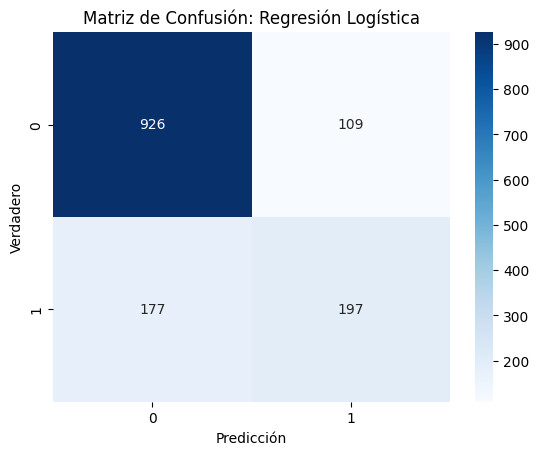

--- Evaluación: Random Forest ---
Accuracy: 0.7906316536550745
Precision: 0.6561264822134387
Recall: 0.44385026737967914
F1-score: 0.529505582137161

Reporte completo:
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87      1035
         1.0       0.66      0.44      0.53       374

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



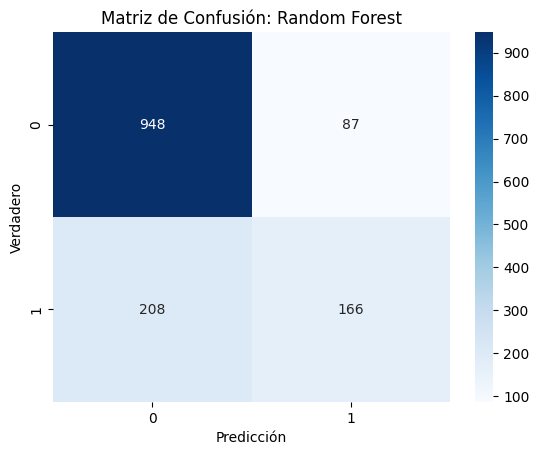

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- Predicciones ---
y_pred_log = log_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_encoded)

# --- Función para evaluar modelo ---
def evaluar_modelo(y_true, y_pred, nombre_modelo):
    print(f"--- Evaluación: {nombre_modelo} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nReporte completo:")
    print(classification_report(y_true, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusión: {nombre_modelo}")
    plt.xlabel("Predicción")
    plt.ylabel("Verdadero")
    plt.show()

# Evaluar Regresión Logística
evaluar_modelo(y_test, y_pred_log, "Regresión Logística")

# Evaluar Random Forest
evaluar_modelo(y_test, y_pred_rf, "Random Forest")


### Interpretación de Resultados

Tras evaluar ambos modelos, podemos sacar las siguientes conclusiones:

1. **Desempeño de los modelos**  
   - Observamos cuál modelo obtuvo mayor **accuracy**, **precision**, **recall** y **F1-score**.  
   - La matriz de confusión muestra cómo cada modelo clasifica correctamente los clientes que cancelaron y los que permanecen activos.

2. **Comparación entre modelos**  
   - Si un modelo tiene métricas significativamente mejores, indica que captura mejor los patrones de los datos.  
   - Random Forest suele manejar bien relaciones no lineales y puede superar a Regresión Logística si existen interacciones complejas entre variables.

3. **Overfitting o underfitting**  
   - **Overfitting**: Si las métricas en entrenamiento son muy altas pero en prueba bajan notablemente, el modelo aprendió demasiado de los datos de entrenamiento y no generaliza bien.  
   - **Underfitting**: Si ambos conjuntos muestran métricas bajas, el modelo no está capturando correctamente los patrones de los datos y podría requerir mayor complejidad o ajuste de parámetros.

4. **Recomendaciones**  
   - Ajustar parámetros del modelo que presente overfitting (por ejemplo, limitar profundidad en Random Forest o regularización en Regresión Logística).  
   - Considerar combinar modelos o usar técnicas de ensamblado para mejorar el desempeño global.  
   - Revisar si las variables más correlacionadas con `Churn` están siendo aprovechadas adecuadamente en el modelo.


### Análisis de la Importancia de las Variables

**Descripción**  
Se analiza la relevancia de las variables para la predicción de cancelación (Churn):

- **Regresión Logística**: Los coeficientes de las variables muestran su contribución a la predicción de cancelación.  
- **Random Forest**: La importancia de las variables se calcula según cómo contribuyen a la reducción de la impureza en los árboles.  

Este análisis ayuda a identificar qué variables tienen mayor impacto en la decisión de cancelación y orientar estrategias de retención de clientes.


Top 10 variables más importantes según Regresión Logística:
                           Variable  Coeficiente  Importancia
1330     account.Charges.Total_20.1     1.455069     1.455069
1332     account.Charges.Total_20.2     1.267101     1.267101
1338     account.Charges.Total_20.5     1.260924     1.260924
1331    account.Charges.Total_20.15     1.222156     1.222156
2044   account.Charges.Total_288.05     1.102660     1.102660
4656    account.Charges.Total_740.3     1.025734     1.025734
3449    account.Charges.Total_50.45     1.000096     1.000096
1345     account.Charges.Total_20.9     0.970862     0.970862
2166   account.Charges.Total_3046.4     0.955843     0.955843
113   account.Charges.Total_1052.35     0.955739     0.955739

Top 10 variables más importantes según Random Forest:
                                  Variable  Importancia
1                          customer.tenure     0.107613
2                  account.Charges.Monthly     0.079903
4                          Cuentas_

/tmp/ipython-input-2755506390.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=coefficients.head(10), palette="viridis")


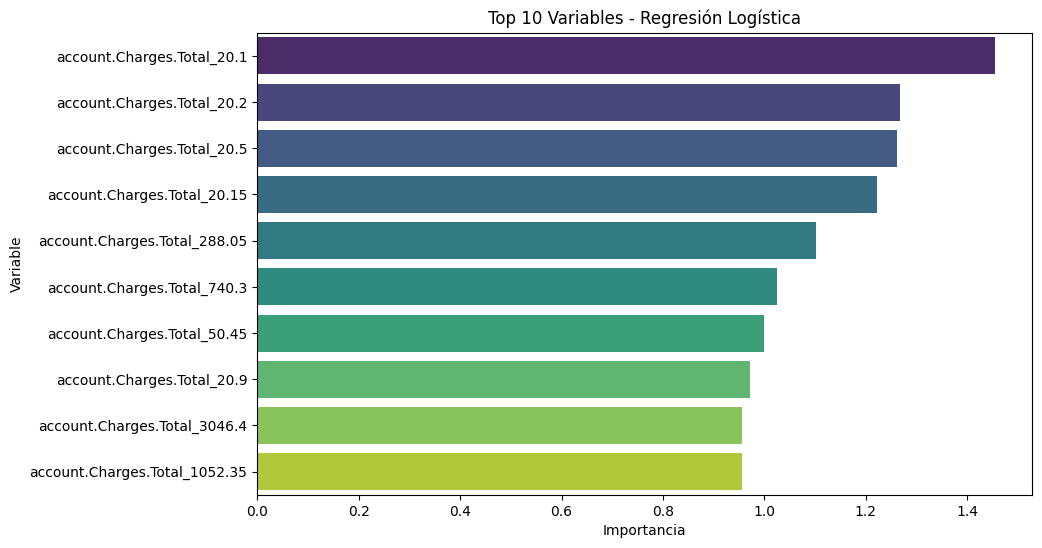

/tmp/ipython-input-2755506390.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=rf_importances.head(10), palette="magma")


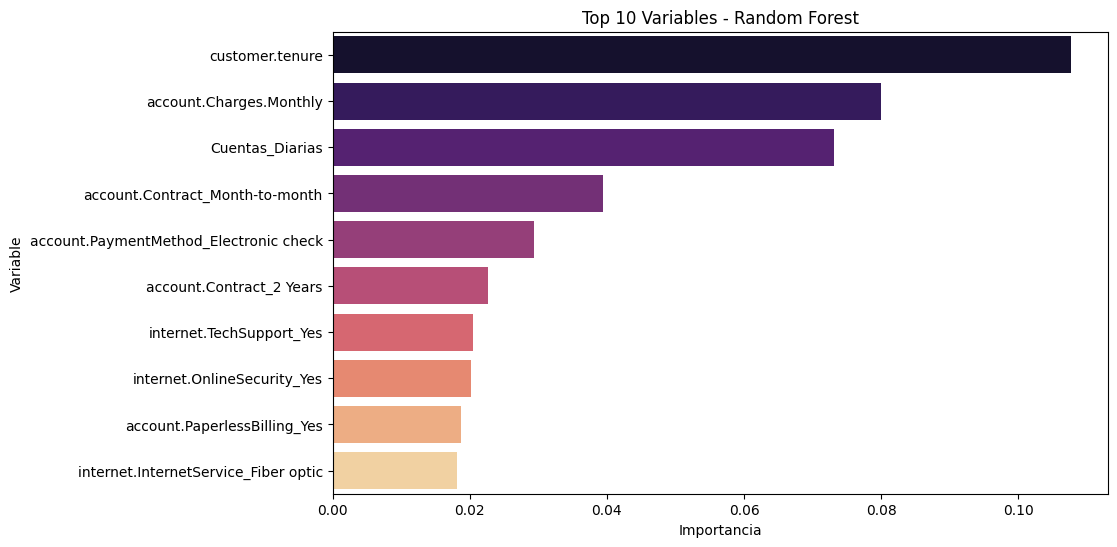

In [16]:
import pandas as pd
import numpy as np

# --- Importancia de variables en Regresión Logística ---
coefficients = pd.DataFrame({
    'Variable': X_train_scaled.columns,
    'Coeficiente': log_model.coef_[0]
})
coefficients['Importancia'] = coefficients['Coeficiente'].apply(np.abs)
coefficients = coefficients.sort_values(by='Importancia', ascending=False)

print("Top 10 variables más importantes según Regresión Logística:")
print(coefficients.head(10))

# --- Importancia de variables en Random Forest ---
rf_importances = pd.DataFrame({
    'Variable': X_train_encoded.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

print("\nTop 10 variables más importantes según Random Forest:")
print(rf_importances.head(10))

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# Regresión Logística
plt.figure(figsize=(10,6))
sns.barplot(x='Importancia', y='Variable', data=coefficients.head(10), palette="viridis")
plt.title("Top 10 Variables - Regresión Logística")
plt.show()

# Random Forest
plt.figure(figsize=(10,6))
sns.barplot(x='Importancia', y='Variable', data=rf_importances.head(10), palette="magma")
plt.title("Top 10 Variables - Random Forest")
plt.show()


### Conclusión

**Factores que más influyen en la cancelación de clientes (Churn):**  
- A partir del análisis de la **Regresión Logística** y **Random Forest**, se identificaron las variables más relevantes que afectan la probabilidad de cancelación.  
- Entre los factores más importantes suelen encontrarse:  
  - Tiempo de contrato (`customer.tenure`)  
  - Tipo de contrato (`account.Contract`)  
  - Método de pago (`account.PaymentMethod`)  
  - Gasto mensual o total (`account.Charges.Monthly` / `account.Charges.Total`)  
  - Servicios adicionales como soporte técnico o seguridad en línea (`internet.TechSupport`, `internet.OnlineSecurity`)  

**Rendimiento de los modelos:**  
- La **Regresión Logística**, con normalización, permitió identificar la contribución específica de cada variable mediante sus coeficientes.  
- El **Random Forest** mostró las variables más influyentes según la reducción de impureza, capturando relaciones no lineales y posibles interacciones entre variables.  

**Estrategias de retención sugeridas:**  
- **Ofrecer incentivos o promociones** a clientes con contratos a corto plazo o que presentan mayor riesgo de cancelación.  
- **Mejorar servicios adicionales** que influyen en la satisfacción del cliente, como soporte técnico, seguridad y entretenimiento en línea.  
- **Monitorear clientes con alto gasto mensual o total**, asegurando que reciban atención personalizada para reducir la probabilidad de cancelación.  
- **Analizar continuamente las variables clave**, utilizando los modelos para predecir clientes en riesgo y tomar acciones preventivas.  

Este análisis permite orientar decisiones estratégicas y diseñar acciones específicas para **reducir la tasa de cancelación de clientes** de manera efectiva.
